# Sistema Multi-Robôs para Cobertura Eficiente de Ambientes Domésticos

- Bernardo Nogueira Borges
- Daniele Cássia Silva Diniz

Uma aplicação relevante na área de robótica é a dos robôs aspiradores, que têm a
função de percorrer o ambiente doméstico de forma autônoma, recolhendo detritos
ao longo do caminho. Este projeto abordará o problema de cobertura no contexto de
sistemas multi-robôs, com o objetivo de dividir a tarefa entre dois robôs. Um dos
principais desafios nesta área é garantir que os robôs executem seu trajeto de forma
eficiente, evitando a movimentação aleatória pelo espaço, como observado em
robôs aspiradores convencionais, conforme demonstrado no [vídeo](https://www.youtube.com/watch?v=qHEJhJ_CuOQ) da Neato
Robotics

Para superar esses desafios, utilizaremos nosso conhecimento em mapeamento,
controle e algoritmos para desenvolver um sistema de multi-robôs que abordará o
problema de **cobertura** do ambiente de forma eficaz, completa e, adicionalmente,
enfrentaremos o desafio de implementar a colaboração entre os robôs. A
implementação será realizada utilizando a linguagem **Python** e o simulador
**CoppeliaSim**.

Abordar este problema é crucial para aumentar a eficiência energética e reduzir a
pegada de carbono dos robôs aspiradores domésticos. Um planejamento adequado
permite que esses robôs executem suas tarefas de maneira mais rápida e eficiente,
contribuindo significativamente para a sustentabilidade ambiental. As principais
aplicações incluem a limpeza autônoma em residências, escritórios e outros
espaços fechados onde a manutenção regular é necessária.

In [54]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import numpy as np
import matplotlib.pyplot as plt

client = RemoteAPIClient()
sim = client.require('sim')
np.set_printoptions(precision=3,suppress=True)

## Obtendo o Mapa da Residência

## Colored Planner

In [55]:
from enum import Enum


class Color(Enum):
    UNSET = 0
    RED = 1
    BLUE = 2


#          UP     RIGHT    DOWN   LEFT
moves = [(-1, 0), (0, 1), (1, 0), (0, -1)]


def validCell(i, j, G):
    N = len(G)
    M = len(G[0])
    return 0 <= i < N \
        and 0 <= j < M \
        and G[i][j] == 0


def bfs_multi(blue_src, red_src, G):
    COLOR_GRAPH = np.zeros(shape=G.shape)

    q = [blue_src, red_src]
    while q:
        (i, j, c) = q.pop(0)
        COLOR_GRAPH[i][j] = c.value

        # Each cell 4-Connect
        for (di, dj) in moves:
            di += i
            dj += j

            # Out of bounds
            if not validCell(di, dj, G):
                continue
            # Already visited
            if COLOR_GRAPH[di][dj] != Color.UNSET.value:
                continue

            q.append((di, dj, c))

    return COLOR_GRAPH


def colorize(G):
    N = len(G)
    M = len(G[0])
    blue_src = None
    for i in range(N):
        for j in range(M):
            if G[i][j] == 0:
                blue_src = (i, j, Color.BLUE)
                break
        if blue_src != None:
            break

    if blue_src == None:
        print("Could not find a blue_src")
        return

    red_src = None
    for i in reversed(range(N)):
        for j in reversed(range(M)):
            if G[i][j] == 0 and (i, j) != (blue_src[0], blue_src[1]):
                red_src = (i, j, Color.RED)
                break
        if red_src != None:
            break

    if red_src == None:
        print("Could not find a red_src")
        return

    return bfs_multi(blue_src, red_src, G)


def plot_color_graph(CG):
    N = len(CG)
    M = len(CG[0])

    # Create a colormap with specified colors
    cmap = plt.cm.colors.ListedColormap(['gray', 'blue', 'red'])
    bounds = [-0.5, 0.5, 1.5, 2.5]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

    # Create the plot
    plt.figure(figsize=(6*(M/N), 6))
    plt.imshow(CG, cmap=cmap, norm=norm)
    plt.colorbar(ticks=[0, 1, 2])
    plt.show()

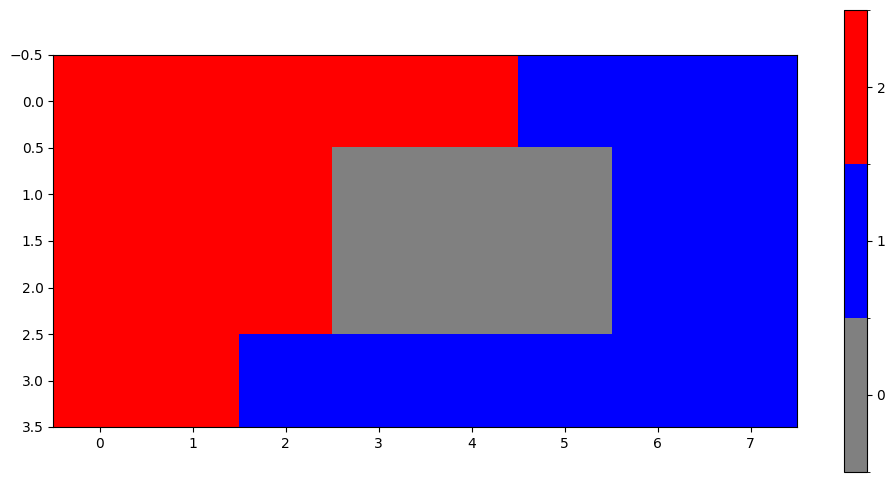

In [56]:
G = np.array([
    [0,0,0,0,0,0,0,0],
    [0,0,0,1,1,1,0,0],
    [0,0,0,1,1,1,0,0],
    [0,0,0,0,0,0,0,0]
])

CG = colorize(G)
plot_color_graph(CG)

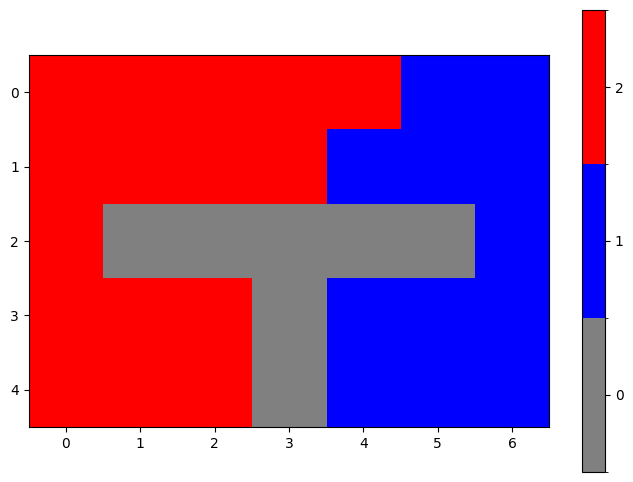

In [57]:
G = np.array([
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,1,1,1,1,1,0],
    [0,0,0,1,0,0,0],
    [0,0,0,1,0,0,0]
])

CG = colorize(G)
plot_color_graph(CG)

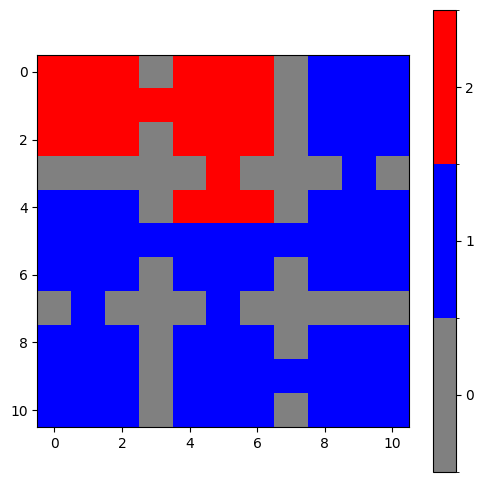

In [58]:
G = np.array([
    [0,0,0,1,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0,0],
    [0,0,0,1,0,0,0,1,0,0,0],
    [1,1,1,1,1,0,1,1,1,0,1],
    [0,0,0,1,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,1,0,0,0],
    [1,0,1,1,1,0,1,1,1,1,1],
    [0,0,0,1,0,0,0,1,0,0,0],
    [0,0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,1,0,0,0]
])

CG = colorize(G)
plot_color_graph(CG)

## Iniciando os Robôs

In [63]:
def Rz(theta):
    return np.array(
        [[np.cos(theta), -np.sin(theta), 0],
         [np.sin(theta), np.cos(theta), 0],
         [0, 0, 1]])


class Robot():
    def __init__(self, name):
        self.name = name
        self.object = sim.getObject(f"/{name}")

        # TODO: Change to robotino, wheels
        self.left_motor = sim.getObject(f"/{name}/kobuki_leftMotor")
        self.right_motor = sim.getObject(f"/{name}/kobuki_rightMotor")

        self.current_goal = None
        self.ERROR_MARGIN = 0.3
        self.gain = [[1.1, 0, 0],
                     [0, 1.1, 0],
                     [0, 0, 1.1]]
        L = 0.230
        r = 0.03

        # Cinemática Direta
        self.Mdir = np.array(
            [[-r/np.sqrt(3), 0, r/np.sqrt(3)],
             [r/3, (-2*r)/3, r/3],
             [r/(3*L), r/(3*L), r/(3*L)]])

    def get_current_position(self):
        pos = sim.getObjectPosition(self.object)
        ori = sim.getObjectOrientation(self.object)
        q = np.array([pos[0], pos[1], ori[2]])
        return q

    def get_goal_positiion(self):
        pass

    def has_reached_goal(self, error):
        return np.linalg.norm(error[:2]) < self.ERROR_MARGIN

    def move_to_goal(self):
        q = self.get_current_position()
        q_goal = self.get_goal_position()
        error = q_goal - q

        if self.has_reached_goal(error):
            # find new goal
            # if no new goal,
            return

        qdot = self.gain @ error
        Minv = np.linalg.inv(Rz(q[2]) @ self.Mdir)
        u = Minv @ qdot

        for i in range(3):
            sim.setJointTargetVelocity(self.wheels[i], u[i])


walle = Robot("WALL_E")
mo = Robot("M_O")
print(walle.name, walle.object, walle.left_motor, walle.right_motor)
print(mo.name, mo.object, mo.left_motor, mo.right_motor)

WALL_E 44 56 61
M_O 81 93 98


## Controle para andar entre células

## Simulação

In [ ]:
sim.stopSimulation()
sim.startSimulation()

MAX_SIMULATION_TIME = 10

while (t := sim.getSimulationtime()) < MAX_SIMULATION_TIME:
    sim.step()